# **Imports**

In [1]:
%pip install langchain
%pip install langchain_openai
%pip install langchain_community
%pip install --upgrade langgraph
%pip install pymupdf
# %pip install gTTs
%pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.9/411.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.29
    Uninstalling langchain-core-0.3.29:
      Successfully uninstalled langchain-core-0.3.29
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.4 MB/s eta 0:00:00


# **Model**

In [2]:
from google.auth import default, transport
import os
from langchain_openai import ChatOpenAI

def get_model():

  ENDPOINT="us-central1-aiplatform.googleapis.com"

  PROJECT_ID = "ai-sandbox-385105"

  LOCATION = "us-central1"


  credentials, _ = default()
  auth_request = transport.requests.Request()
  credentials.refresh(auth_request)
  os.environ["access_token"] = credentials.token

  agent405B = ChatOpenAI(
      model="meta/llama3-405b-instruct-maas",
      base_url="https://us-central1-aiplatform.googleapis.com/v1beta1/projects/ai-sandbox-385105/locations/us-central1/endpoints/openapi/chat/completions?",
      api_key=os.getenv("access_token"),
      temperature=0,
      max_tokens=None,
      timeout=None,
      max_retries=2,
      include_response_headers=True,

  )

  return agent405B

In [ ]:
get_model().invoke("What is the capital of India?")

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 7, 'total_tokens': 15, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta/llama3-405b-instruct-maas', 'system_fingerprint': '', 'headers': {'content-type': 'application/json', 'vary': 'Origin, X-Origin, Referer', 'content-encoding': 'gzip', 'date': 'Fri, 17 Jan 2025 11:33:52 GMT', 'server': 'scaffolding on HTTPServer2', 'x-xss-protection': '0', 'x-frame-options': 'SAMEORIGIN', 'x-content-type-options': 'nosniff', 'transfer-encoding': 'chunked'}, 'finish_reason': 'stop', 'logprobs': None}, id='run-55ef5188-b6e7-4e90-bf21-373e9847701d-0', usage_metadata={'input_tokens': 7, 'output_tokens': 8, 'total_tokens': 15, 'input_token_details': {}, 'output_token_details': {}})

In [ ]:
import json

config_data = json.load(open("config.json"))
MERCOR_OPENAI_KEY = config_data["MERCOR_OPENAI_KEY"]
# print(MERCOR_OPENAI_KEY)

In [ ]:
from openai import OpenAI
import os

client = OpenAI(
    api_key = MERCOR_OPENAI_KEY
)

def get_completion_model(user_prompt):
  response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
          {"role": "system", "content": "You are a helpful assistant."},
          {
              "role": "user",
              "content": user_prompt
          }
      ],
      max_tokens = 500
  )
  return response.choices[0].message.content

print(get_completion_model("what is capital of India?"))

The capital of India is New Delhi.


# **GraphState**

In [ ]:
from langgraph.graph import StateGraph, END , START
from typing import TypedDict, Optional, List , Annotated , Dict
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage, SystemMessage , AIMessage
import ipywidgets as widgets
from IPython.display import display
import PyPDF2

class GraphState(TypedDict):
  file_path: str
  file_contents: str
  candidate_info : Dict[str,str]
  candidate_level: str
  messages: Annotated[list,add_messages]
  feedback:str


In [ ]:
import fitz
from langchain_core.messages import HumanMessage, SystemMessage , AIMessage
# from gtts import gTTS
import os
# from IPython.display import Audio


# **Extraction agent**

In [ ]:
def pdf_processing_agent(state):

  file_path = "Shirisha_Manthoju_Resume.pdf"
  pdf_document = fitz.open(file_path)

  page_content = ""
  for page_num in range(len(pdf_document)):
      page = pdf_document[page_num]
      page_content += page.get_text()
  pdf_document.close()

  return {"file_contents":page_content}

In [ ]:

def extraction_agent(state):

  resume_context_prompt= f"""

  Your task is to categorize the given information of user from the below context in the following format
    1) Their Personal Information
    2) Their Skills
    3) Their Work Experince
    4) Their Projects

  Context:
  {state.get("file_contents")}

  give the json response in the below format:
    `skills`: `list of skills in the candidate info`,
    `previous_work_experience` : `Previous work experience`
    `projects`: `candidate's projects`

  Your Response should be clear , concise and accurate
  """

  response = get_model().invoke(resume_context_prompt)
  state = {"candidate_info":response.content}
  print(f"Extraction agent ...", state)
  return state


# **Mercor Resumes**

In [ ]:
context_1_MJ = """
  Expert in: Java, React , Javascript , Python

  Work Experience :

  Software Development Engineer
  Amazon ( 2023 - Present )
  Developed and optimized high-performance middleware software for in-vehicle infotainment (IVI) systems, delivering efficient and robust solutions in a fast-paced environment. Enhanced system architecture, resolving critical performance bottlenecks and significantly improving the overall reliability and success of the IVI platform. Designed and implemented a comprehensive load-testing framework, which was reviewed and approved by senior stakeholders, and integrated it into the CI/CD pipeline, reducing manual testing time by 40%. Identified and resolved a critical performance bottleneck caused by excessive use of Regex, resulting in a 90% reduction in CPU clock time for sending notifications and a 60% decrease in delayed notifications. Ensured seamless system integration by developing ABI-stable APIs and implementing an IPC framework for efficient and secure inter-process communication connections. Conducted thorough code reviews, ensuring coding standards and best practices, and provided constructive feedback to team members. Improved system performance and reliability by testing and debugging software components, resulting in a 25% increase in efficiency, and wrote comprehensive unit and integration tests using GTest. Collaborated with diverse, cross-functional teams, including key US-based teams, to align development efforts with global standards and ensure seamless integration across various regions and complex platforms. Guided and mentored new developers, contributing to team growth and maintaining high code standards.


  Software Development Engineer Intern
  Amazon (2022 - 2022)
  Developed and enhanced critical features in the Pay On Delivery system, focusing on efficient and user-friendly solutions. Collaborated with cross-functional teams to ensure successful project outcomes, earning high praise and a preplacement offer for completing three key projects within two months. Designed and developed a Java-based API using API Gateway, enabling efficient downloading of rule sets for offline review and boosting developer efficiency. Utilized SuperCSV to convert POJOs to CSV files, ensuring seamless data handling and integration, and wrote comprehensive unit tests using Mockito to verify functionality and maintain high code quality. Created a detailed, color-coded version control visualization feature using React Diff Viewer, enhancing accuracy and usability for developers and product managers. Developed a sophisticated advanced search filter using React, enabling multi-criteria search of rules and significantly enhancing the user experience for Product Managers. Authored detailed documentation for developed APIs and features, ensuring clear communication and ease of maintenance.

  Education

    B.Tech (2023)
    Indian Institute of Technology Kharagpur

  Awards

  1. Senior JBNSTS Scholar: Awarded the prestigious JBNSTS Scholarship, recognizing top academic and scientific talent among students in India.

  2. IIT JEE Advanced: Successfully passed the highly competitive IIT JEE Advanced exam, securing admission to the prestigious IIT Kharagpur.

  3. Board Ranks: Achieved Board Rank 9 in both Higher Secondary and Secondary exams, standing out among over 1 million students.

  Projects

  1. Expense Tracker - Developed a web-based Expense Tracker using React, enabling users to track expenses, categorize transactions, and view detailed reports. Enhanced usability and accessibility by integrating voice command functionality, allowing users to add expenses or income via voice commands.

  2. Music App - Developed a React-based web app that fetches songs by genre and location via third-party APIs, providing users with a personalized experience featuring top charts and artists. Integrated third-party APIs to dynamically fetch and display trending music and artist information across various regions, enhancing the app's functionality.

"""

context_2_RC = """
  Expert  :
   React , Python , Django ,PostgreSQL, JavaScript

  Work Experience

  Software Engineer (2024 - Present)
  CobolCopilot

    Accelerating COBOL project delivery 10x by engineering cloud-based development environment to help developers understand, maintain, navigate, document and write COBOL code using AI autocomplete, prompt to codegen, and real time summaries with proprietary SOTA models (LLMs, Cloudflare Workers, React, Django, Socket.io, Postgres). Finetuned open-source models and evaluated performance against COBOLEval metrics.

  Software Engineer Intern (2023 - 2024)
  Coinbase

    Implemented complex error management on retail trade features to improve user experience and decrease blocking errors by 40% by gracefully handling network and service failures. Simplified Relay caching logic and filtering to decrease cold-start load times by ~30ms for iOS & Android App. Currently resolving data synchronization issues between critical services (Ledger and Account History) to enable higher fidelity portfolio performance metrics and 1099K tax compliance.

  Software Engineering Manager & Software Engineer (2022 - 2024)
  ChangePlusPlus

    Facilitated frequent discussions with clients to construct and iterate Figma wireframe, PRD, and web app. Engineered web-app for NGO to track beneficiary data and growth over time, allowing for real-time data analytics. This resulted in a 20x speedup in rendering impact reports.

  Full Stack Software Engineering Intern (2022 - 2022)
  UnitedHealth Group (Optum)

    Saved analysts 4 hours/week by engineering a dashboard application to automatically view, parse, and edit 837-HIPAA files. Optimized existing back-end by implementing pagination and indexing foreign keys to reduce query time by 2300 ms. Directed modeling of API endpoints for seamless frontend-backend integration.

  Software Engineering Intern (2022 - 2022)
  Institute for Software Integrated Systems

    Spearheaded full-stack development of a dashboard app that stores traffic, license, and animal data via optical character recognition to improve neighborhood safety. Increased training data size by a factor of 20x by engineering Python script to scrape web images of number plates and cars. Improved previous web page quality & load time through React Lazy Load, increasing Lighthouse performance by 120%.


  Education :
  Bachelors of Science
  Vanderbilt University
  2024

  Projects :
  1. Wannajob - Acquired over 800 DAU by engineering an AI resume review service to provide high-quality resume feedback at scale.

  2. CRM Genie (CRM Co-pilot) - Developed integration between OpenAI & Salesforce that enables business reps to gain key insights using natural language processing which speeds up data analysis by 500%+ compared to report generation.

  3. GradeGuru - Engineered a SaaS web-app to improve the grading workflow of teachers 20x with AI.

  4. Autonomous Vehicle Simulation - Developed a fully autonomous vehicle within a Julia simulator; Required 4 separate modules for Perception, Localization, Decision making, and Routing.

"""


context_3 = """
  Expert  : React, Redux, TypeScript , SQL, Java, Linux OS, Go lang

  Work Experience :

    Software Engineer
    IBM (2021 - Present)
    Working alongside a great team in order to maintain and add new features to 2 Internal Applications that are using different technologies. My main assignment consist of the full lifecycle of a task, from business analysis to implementation. Applications stack: 1. React&Redux, Typescript, .Net 6, Microsoft SQL Server 2.Angular, Typescript, .Net 6, Microsoft SQL Server

    Software Engineer
    IOTNetPRO (2019 - 2021)
    Worked with technologies like React, Redux, .Net and Microsoft SQL to develop a SaaS platforms, making decisions about how the features should work and how we can make the UI/UX better.

  Education:
    Licenta, Informaticà
    University of Bucharest (2016 - 2019)

"""

context_4_KS = """
    Expert in : Java, Python, SQL , Excel

    Work Experience :

    Member of Technical Staff -2 (MTS-2)
    Oracle Pvt. Ltd (2021 - Present)
     - Enhanced and secured customer onboarding by externalizing server credential and collaborated with the global compliance team to achieve GA. Seamlessly incorporated Oracle's Audit service into all customer-exposed APIs, guaranteeing an extensive and robust audit functionality. Gathered data from 10+ sources to create a comprehensive Infrastructure report, offering a holistic view that empowers stakeholders with crucial details like Client IDs, VM clusters, and their states. Pioneered a strategic framework to pinpoint affected customers during scheduled outages and ensure timely notifications. Enhanced existing workflow models to support storage server software upgrade to the latest available Oracle Linux distribution. Developed a Python script that revolutionized our label uptake process, resulting in a significant time-saving of over 8 hours per month. Technologies Used: Git, Java, Python, SQL, REST, Excel, Postman, Dropwizard, CI/CD etc.

    Education

    Bachelor of Engineering
    Indraprastha Institute of Information Technology, Delhi (IIITD) (2017 - 2021)

    Projects

    - Movie Inventory System - Lead a team of 4 for development of the movie inventory system, showcasing a wide array of essential features, including movie listings, seamless purchases, rentals, and comprehensive profit analysis on both quarterly and annual scales for Admin. This cutting-edge system was further fine-tuned through the use of indexes, views, and optimizations, resulting in a truly exceptional cinematic experience for users. Tools and Technology used: Java, MySQL.

    - Snake v/s Block Game - Java Based UI Game - Developed an engaging game allowed users to create accounts, enjoy interactive gameplay, and maintain score records within a MySQL database. Utilized Java, JavaFX, and MySQL technologies to deliver a popular and immersive gaming experience.

"""


context_5_MJ_WO_Exp = """
  Expert in: Java, React , Javascript , Python

  Education

    B.Tech (2023)
    Indian Institute of Technology Kharagpur

  Awards

  1. Senior JBNSTS Scholar: Awarded the prestigious JBNSTS Scholarship, recognizing top academic and scientific talent among students in India.

  2. IIT JEE Advanced: Successfully passed the highly competitive IIT JEE Advanced exam, securing admission to the prestigious IIT Kharagpur.

  3. Board Ranks: Achieved Board Rank 9 in both Higher Secondary and Secondary exams, standing out among over 1 million students.

  Projects

  1. Expense Tracker - Developed a web-based Expense Tracker using React, enabling users to track expenses, categorize transactions, and view detailed reports. Enhanced usability and accessibility by integrating voice command functionality, allowing users to add expenses or income via voice commands.

  2. Music App - Developed a React-based web app that fetches songs by genre and location via third-party APIs, providing users with a personalized experience featuring top charts and artists. Integrated third-party APIs to dynamically fetch and display trending music and artist information across various regions, enhancing the app's functionality.

"""

context_6_RC_WO_Exp = """
  Expert  :
   React , Python , Django ,PostgreSQL, JavaScript

  Education :
  Bachelors of Science
  Vanderbilt University
  2024

  Projects :
  1. Wannajob - Acquired over 800 DAU by engineering an AI resume review service to provide high-quality resume feedback at scale.

  2. CRM Genie (CRM Co-pilot) - Developed integration between OpenAI & Salesforce that enables business reps to gain key insights using natural language processing which speeds up data analysis by 500%+ compared to report generation.

  3. GradeGuru - Engineered a SaaS web-app to improve the grading workflow of teachers 20x with AI.

  4. Autonomous Vehicle Simulation - Developed a fully autonomous vehicle within a Julia simulator; Required 4 separate modules for Perception, Localization, Decision making, and Routing.

"""


In [ ]:
def extraction_agent(state):
  resume_context = f"""
  You are an agent in extracting the information for larger context, your task is to categorize the given
  information of candidate from the below context.
  Ensure that no details are omitted or summarized in a way that reduces clarity or richness.
  Include specific methodologies, technical implementations, and advanced techniques whenever mentioned.

  Context : {context_5_MJ_WO_Exp}

  # JSON Response Format #
  `personal_information` : 'Details such as the candidate's name and other relevant personal data.'
  `skills` : 'A list of all technical and non-technical skills mentioned, categorized where possible.'
  `work_experience`: 'Detailed descriptions of the candidate's previous roles, including responsibilities, achievements, and technologies used, without omitting any information.'
  `projects`: 'Comprehensive information about the candidate's projects, including project goals, technologies used, candidate contributions, outcomes, and methodologies. Highlight any advanced techniques or expertise demonstrated in these projects.'

  If particular section is not provides, mention them by giving 'not provided'
  """

  # llama model
  response = get_model().invoke(resume_context)
  state = {"candidate_info":response.content}

  # gpt-4o-mini model
  # response = get_completion_model(resume_context)
  # state = {"candidate_info":response}
  print(f"Extraction agent ...", state)
  return state

# **Interviewer_Agent**

In [ ]:
# def Interviewer_Agent(state):
#   new_message = [
#       SystemMessage(
#           content = f"""
#           # CONTEXT #

#           You are an experienced technical interviewer agent with 20+ years of experience conducting adaptive interviews.
#           Your task is to conduct interview for a candidate based on their resume and work experience. The interview should include the discussion of their work experiences and responses to case studies.

#           Review the candidate information: Candidate_info: {state.get("candidate_info")}

#           # OBJECTIVE #
#           - Assess the candidate's technical and problem-solving abilities. Understand their thought process and approach to real-world scenarios through case studies and discussions of their experiences.

#           # STYLE #
#           - Adapt and conversational

#           # TONE #

#           - Be conversational and approachable to put the candidate at ease.
#           - Focus on uncovering the candidate’s thought process, creativity, and depth of knowledge.
#           - Maintain a balance between technical and behavioral questions to gain a holistic view of the candidate’s capabilities.

#           # AUDIENCE #

#           - A candidate with technical skills and project experience, as detailed in the provided resume.
#           - The candidate is familiar with the technologies and methodologies mentioned in their work history.

#           # RESPONSE FORMAT #

#           - You may use brief acknowledgments (e.g., 'Interesting', 'I see', 'Great')
#           - You ask 'ONLY ONE' question at a time.
#           - Focus next questions based on the depth and quality of previous response
#           - Maintain natural conversation flow while probing technical depth.

#           # GUIDELINES #

#           - Avoid direct questions about skills listed in the resume. Instead, infer their application in projects and experiences.
#           - Ask open-ended, scenario-based questions to explore their decision-making and creativity.
#           - Avoid giving detailed explanation for candidate's responses.

#           ## INTERVIEW FLOW

#           # Introduction :

#             - Start by warmly greeting the candidate and confirming their readiness in one line.

#           # Interview Guidelines:

#             - Connect the mentioned skills in the work experience and the projects and then ask questions accordingly.
#             - If both projects and experiences are present , focus on candidate experiences and start from experiences.
#             - If candidate has no experience mentioned, then go with projects and ask questions on DSA and algorithms.
#             - Ask questions that explore the candidate's experience and projects without directly referencing the skills in their resume.
#             - Ask follow up questions based on the depth and quality of previous responses.

#           # Experience Discussion :
#             - Ask about responsibilities and technical challenges.
#             - Connect work experience with skills mentioned.
#             - Discuss specific technical implementations.

#           # Project Discussion :
#             - Ask about their specific role and contributions.
#             - Follow up on technical decisions and challenges mentioned.
#             - Explore the technologies they used in context.

#           # Case Study/Scenario-Based Questions :
#             - After completing the experience and projects discussion , you present a case study or scenario that aligns with the candidate's domain or based on the work that candidate was part of.
#             - For example:
#              'Imagine you are tasked with optimizing a React application that has performance issues during rendering. How would you approach diagnosing and resolving this problem?'
#              'Suppose you're designing a RESTful API for a healthcare platform. How would you structure the API to ensure scalability and security?'

#           # Closing : Conclude the interview by saying 'COMPLETED', without any explanation. when you have thoroughly assessed their skills and projects.

#           Remember: Your goal is to understand both their knowledge breadth and depth through adaptive questioning, Maintain natural conversation throughout the interview.

#           """
#       ),
#       HumanMessage(content = " ")
#   ]

#   while(True):
#     ai_input = get_model().invoke(new_message)
#     if("COMPLETED" in ai_input.content):
#       print("Interviewer: Thanks for taking the time to interview with us! We will reach out to you with next steps shortly.")
#       break

#     print(f"Interviewer: {ai_input.content}")
#     candidate_input = input("Candidate_Response: ")

#     new_message.append(AIMessage(content=ai_input.content))
#     new_message.append(HumanMessage(content=candidate_input))

#   return {"messages":new_message}

In [ ]:
# def interviewer_Agent(state):
#   new_message = [
#     SystemMessage(
#         content = f"""
#       You are an experienced technical interviewer with over 20 years of expertise in conducting adaptive interviews.

#       Your task is to review the candidate's profile and experience level, then tailor the interview accordingly based on their level.
#       Candidate Information: {state.get("candidate_info")}
#       Candidate Level: {state.get("candidate_level")}

#       Adhere strictly to the following Interview Guidelines, Response Format, and Interview Flow throughout the entire process to ensure smooth interaction with the candidate.

#       ## RESPONSE FORMAT

#       1. Use brief and appropriate acknowledgments (e.g., 'Interesting', 'I see', 'Great').
#       2. Ask 'ONLY ONE' question at a time, ensuring clarity and focus.
#       3. Adapt subsequent questions based on the quality and depth of the candidate's previous answers.
#       4. Maintain a natural conversational flow, probing for technical depth where necessary.
#       5. Avoid providing explanations or interpretations of the candidate’s responses focus on the interview.

#       ## Interview Guidelines

#       - Start with a warm greeting and confirm the candidate’s readiness in one line.
#       - Relate the candidate's listed skills to their actual experience in projects and work; do not directly question listed skills.
#       - Frame questions based on the application of skills, especially in the context of projects and work experience.
#       - Ask open-ended, scenario-based questions to gauge decision-making and problem-solving abilities.
#       - Do not provide detailed feedback on candidate responses, instead keep the focus on asking further probing questions.

#       ## Interview Flow Based on Candidate Level

#       **If the Candidate Level is a 'Beginner':**

#         1. Start with project-related questions, their role , contributions, follow up on challenges, technologies.
#         2. Also ask questions from Data Structures, Algorithms, and advanced problem-solving scenarios.
#         2. Ask scenario-based questions that require a combination of DSA knowledge and problem-solving skills.
#         3. Relate their listed skills with projects they’ve worked on and discuss those in depth to evaluate their expertise.

#       **If the Candidate Level is 'Intermediate' :**
#         1. For each work experience:
#           - Inquire about responsibilities and technical challenges faced.
#           - Connect their work experience with the skills they listed.
#           - Discuss specific technical implementations they were part of.

#         2. For each significant project:
#           - Ask about their specific role and contributions.
#           - Follow up on any technical decisions or challenges they encountered.
#           - Explore how they applied the technologies they used in those projects.

#         3. Dive deep into their projects or experiences as needed to gain a thorough understanding of their approach and learning.

#       Follow up with questions based on the depth of their responses to keep the conversation progressing.
#       Conclude by presenting a relevant case study or scenario, ideally linked to their domain or work area.
#       End the interview by saying 'COMPLETED' once you've thoroughly assessed the candidate’s skills, knowledge, and experiences.

#       Remember: Your goal is to understand the candidate’s knowledge breadth and depth, and you must achieve this by following an adaptive and natural conversation style, ensuring a clear and effective interview process.
#       """

#     ),
#     HumanMessage(content=" ")
#   ]

#   while(True):
#     ai_input = get_model().invoke(new_message)
#     if("COMPLETED" in ai_input.content):
#       print("Interviewer: Thanks for taking the time to interview with us! We will reach out to you with next steps shortly.")
#       break

#     print(f"Interviewer: {ai_input.content}")
#     candidate_input = input("Candidate_Response: ")

#     new_message.append(AIMessage(content=ai_input.content))
#     new_message.append(HumanMessage(content=candidate_input))

#   return {"messages":new_message}

# **Interview_agent_llama_model**

In [ ]:
def interview_agent(state):
  new_message = [
    SystemMessage(
       content = f"""
       You are an experienced technical interviewer with 20 years of experience conducting adaptive interviews.

       Review the candidate information
       Candidate_info: {state.get("candidate_info")}

       You must strictly follow the given Interview guidelines , response format during the
       entire interview process for smooth Interaction with candidate.

       ## Response Format

        - Use brief, thoughtful acknowledgments (e.g., 'Interesting', 'I see', 'Great') to encourage the candidate, but refrain from offering detailed explanations for their responses.
        - Ask 'ONLY ONE' focused question at a time to maintain clarity.
        - Tailor your follow-up questions based on the depth and quality of the candidate’s previous response, digging deeper into areas that warrant further exploration.
        - Maintain a natural, conversational flow, ensuring the discussion feels engaging while probing into the technical details with depth and clarity.

       ## Interview Guidelines

        - Striclty Start by warmly greeting the candidate and confirming their readiness in one line.
        - Instead of directly asking about the skills listed in the resume, connect those skills to the candidate's work experience's and projects, and ask how they applied them in real-world scenario.
        - If a skill mentioned in the resume is not implemented in any of the projects or experiences, ask the candidate where and how they have used that skill.
        - Ask open-ended, scenario-based or case study questions to explore their decision-making, that would relate to the work or projects they have done, to better understand their problem-solving approach.
        - Craft concise, engaging follow-up questions that delve deeper into the candidate's specific achievements or challenges, emphasizing quantitative outcomes and practical implementations and avoid overly broad or introductory questions, focusing instead on technical depth and actionable insights.

        ## Interview Flow

        1. If both projects and experiences are present, prioritize experiences first and then projects if necessary.
        2. If candidate has no experience mentioned :
          - Start with project-related questions. Also ask questions from Data Structures, Algorithms, and advanced problem-solving scenarios.
          - Ask scenario-based questions that require a combination of DSA knowledge and problem-solving skills.
        3. For each significant project:
          - Ask about their specific role and contributions.
          - Follow up on technical decisions and challenges mentioned.
          - Explore the technologies they used in context.
        4. For each work experience :
          - Ask about responsibilities and technical challenges.
          - Connect work experience with skills mentioned.
          - Discuss specific technical implementations.
        5. Have a deep discussion to understand their work and projects clearly whenever required.
        6. Ask follow up questions based on the depth and quality of previous responses.
        7. After completing the experience and projects discussion , you present a case study or scenario that aligns with the
           candidate's domain or based on the work that candidate was part of and ask follow up if required.

      End the interview by saying 'COMPLETED', without any explanation. when you have thoroughly assessed their skills and projects.

      Remember: Your goal is to understand both their knowledge breadth and depth through adaptive questioning, Maintain natural conversation throughout the interview.

    """
    ),
    HumanMessage(content=" ")
  ]

  while(True):
    ai_input = get_model().invoke(new_message)
    if("COMPLETED" in ai_input.content):
      print("Interviewer: Thanks for taking the time to interview with us! We will reach out to you with next steps shortly.")
      break

    intermediate_prompt = f"""
    Analyze the context and provide a one-line acknowledgment or appreciation that aligns with the topic. Then, restate the provided follow-up question seamlessly without explicitly stating it is a follow-up.
    Context : {ai_input.content}

    Example Context:
    *'That's a very detailed explanation of your thought process and the steps you took to identify and solve the problem. It sounds like you used a combination of logging, profiling tools, and debugging to pinpoint the issue with the Regex functions. I'm impressed that you were able to reduce the CPU clock time for sending notifications by 90%.
    You mentioned that you replaced the Regex library with normal string comparisons using the strcmp function in C++. Can you tell me more about why you chose this approach, and how you ensured that the new implementation was correct and efficient?'*
    Output:
    'Achieving such a substantial performance improvement highlights your keen optimization expertise. Could you tell me more about why you chose this approach and how you ensured the new implementation was correct and efficient?'

    """

    concise_response = get_model().invoke(intermediate_prompt)
    print(f"initial_quesion: {ai_input.content}")
    print(f"Interviewer: {concise_response.content}")

    candidate_input = input("Candidate_Response: ")

    new_message.append(AIMessage(content = concise_response.content))
    new_message.append(HumanMessage(content=candidate_input))

  return {"messages":new_message}

# **Interview agent with gpt model**

In [ ]:
def get_completion_model_1(messages):
  response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages= messages,
      max_tokens = 500
  )
  return response.choices[0].message.content


In [ ]:
def interview_agent(state):

  system_content = f"""
      You are an experienced technical interviewer with 20 years of experience conducting adaptive interviews.

      Review the candidate information
      Candidate_info: {state.get("candidate_info")}

      You must strictly follow the given Interview guidelines , response format during the
      entire interview process for smooth Interaction with candidate.

      ## Response Format

      - Use brief, thoughtful acknowledgments (e.g., 'Interesting', 'I see', 'Great') to encourage the candidate, but refrain from offering detailed explanations for their responses.
      - Ask 'ONLY ONE' focused question at a time to maintain clarity.
      - Tailor your follow-up questions based on the depth and quality of the candidate’s previous response, digging deeper into areas that warrant further exploration.
      - Maintain a natural, conversational flow, ensuring the discussion feels engaging while probing into the technical details with depth and clarity.

      ## Interview Guidelines

      - Striclty Start by warmly greeting the candidate and confirming their readiness in one line.
      - Instead of directly asking about the skills listed in the resume, connect those skills to the candidate's work experience's and projects, and ask how they applied them in real-world scenario.
      - If a skill mentioned in the resume is not implemented in any of the projects or experiences, ask the candidate where and how they have used that skill.
      - Ask open-ended, scenario-based or case study questions to explore their decision-making, that would relate to the work or projects they have done, to better understand their problem-solving approach.
      - Craft concise, engaging follow-up questions that delve deeper into the candidate's specific achievements or challenges, emphasizing quantitative outcomes and practical implementations and avoid overly broad or introductory questions, focusing instead on technical depth and actionable insights.

      ## Interview Flow

      1. If both projects and experiences are present, prioritize experiences first and then projects if necessary.
      2. If candidate has no experience mentioned :
        - Start with project-related questions. Also ask questions from Data Structures, Algorithms, and advanced problem-solving scenarios.
        - Ask scenario-based questions that require a combination of DSA knowledge and problem-solving skills.
      3. For each significant project:
        - Ask about their specific role and contributions.
        - Follow up on technical decisions and challenges mentioned.
        - Explore the technologies they used in context.
      4. For each work experience :
        - Ask about responsibilities and technical challenges.
        - Connect work experience with skills mentioned.
        - Discuss specific technical implementations.
      5. Have a deep discussion to understand their work and projects clearly whenever required.
      6. Ask follow up questions based on the depth and quality of previous responses.
      7. After completing the experience and projects discussion , you present a case study or scenario that aligns with the
         candidate's domain or based on the work that candidate was part of and ask follow up if required.

    End the interview by saying 'COMPLETED', without any explanation. when you have thoroughly assessed their skills and projects.

    Remember: Your goal is to understand both their knowledge breadth and depth through adaptive questioning, Maintain natural conversation throughout the interview.

    """
  new_message = [
      {
          "role": "system",
          "content" : system_content
      }
    ]

  while(True):
    ai_input = get_completion_model_1(new_message)
    if("COMPLETED" in ai_input):
      print("Interviewer: Thanks for taking the time to interview with us! We will reach out to you with next steps shortly.")
      break

    print(f"Interviewer: {ai_input}")

    candidate_input = input("Candidate_Response: ")

    new_message.append({"role":"assistant","content" : ai_input})
    new_message.append({"role":"user","content" : candidate_input})


  return {"messages":new_message}

# **Feedback Agent**

In [ ]:
def feedback_agent(state):

  messages = state.get("messages",[])

  ai_messages = []
  human_messages = []


  for msg in messages:
    if isinstance(msg,AIMessage):
      ai_messages.append(msg.content)
    elif isinstance(msg,HumanMessage):
      human_messages.append(msg.content)

  feedback_agent_prompt = f"""
    You are an Feedback agent specialized in giving feedbacks to the candidates who attend for interviews in SDE roles.
    Your task is to analyze the candidate's responses to the asked questions and provide structured feedback.
    Candidate_details:{state.get("candidate_info")}
    1. Analyze the candidate's answers provided : {human_messages}.
    2. Consider the questions that were asked: {ai_messages}.

    Your feedback should include:
    - Their name info , location , their experience and other info provided
    - A **summary** of the candidate's performance.
    - **Strong Points**: Highlight areas where the candidate performed well or demonstrated expertise.
    - **Weak Points**: Identify areas where the candidate struggled or lacked clarity.
    - **Areas for Improvement**: Provide actionable suggestions for how the candidate can improve in the weak areas.

    After the analysis, classify the candidate into one of the following categories:
    - **Accepted**: Candidate excels and meets/exceeds expectations for the role.
    - **Rejected**: Candidate does not meet the requirements for the role.

    Provide a clear explanation for your classification.
    Do not provide the questions , just generate a report for the following json object
    `name`: candidate_name retrieved from candidate info
    `email`: candidate_email retieved from candidate info
    `summary`:candidate overall performance
    `strong_points`:Array of strong points
    `weak_points`:Array of weak points
    `improvement`:Areas of improvements
    `decision`:Accepted/Rejected

    no explanation required, return only json object with the above following keys.
    """

  response = get_model().invoke(feedback_agent_prompt)
  print(response.content)
  return {"feedback":response.content}
  # response = get_completion_model(feedback_agent_prompt)
  # print(response)
  # return {"feedback":response}


# **Graph Nodes and Graph Edges**

In [ ]:
graph_builder = StateGraph(GraphState)

# graph_builder.add_node("pdf_processing",pdf_processing_agent)
graph_builder.add_node("extraction_agent",extraction_agent)
graph_builder.add_node("interviewer_agent",interview_agent)
graph_builder.add_node("feedback_agent",feedback_agent)
# graph_builder.add_node("email_agent",email_agent)


# graph_builder.set_entry_point("pdf_processing")
# graph_builder.add_edge("pdf_processing","extraction_agent")
graph_builder.set_entry_point("extraction_agent")
graph_builder.add_edge("extraction_agent","interviewer_agent")
graph_builder.add_edge("interviewer_agent","feedback_agent")
graph_builder.add_edge("feedback_agent",END)
# graph_builder.add_edge("email_agent",END)


In [ ]:
app = graph_builder.compile()

inputs = {"messages":[]}

app.invoke(inputs)



Extraction agent ... {'candidate_info': 'Here is the categorized information for the candidate in the JSON response format:\n\n```\n{\n  "personal_information": "not provided",\n  "education": {\n    "degree": "B.Tech",\n    "year": 2023,\n    "institution": "Indian Institute of Technology Kharagpur"\n  },\n  "awards": [\n    {\n      "name": "Senior JBNSTS Scholar",\n      "description": "Awarded the prestigious JBNSTS Scholarship, recognizing top academic and scientific talent among students in India."\n    },\n    {\n      "name": "IIT JEE Advanced",\n      "description": "Successfully passed the highly competitive IIT JEE Advanced exam, securing admission to the prestigious IIT Kharagpur."\n    },\n    {\n      "name": "Board Ranks",\n      "description": "Achieved Board Rank 9 in both Higher Secondary and Secondary exams, standing out among over 1 million students."\n    }\n  ],\n  "skills": {\n    "programming_languages": ["Java", "Javascript", "Python"],\n    "frameworks": ["Rea

{'candidate_info': 'Here is the categorized information for the candidate in the JSON response format:\n\n```\n{\n  "personal_information": "not provided",\n  "education": {\n    "degree": "B.Tech",\n    "year": 2023,\n    "institution": "Indian Institute of Technology Kharagpur"\n  },\n  "awards": [\n    {\n      "name": "Senior JBNSTS Scholar",\n      "description": "Awarded the prestigious JBNSTS Scholarship, recognizing top academic and scientific talent among students in India."\n    },\n    {\n      "name": "IIT JEE Advanced",\n      "description": "Successfully passed the highly competitive IIT JEE Advanced exam, securing admission to the prestigious IIT Kharagpur."\n    },\n    {\n      "name": "Board Ranks",\n      "description": "Achieved Board Rank 9 in both Higher Secondary and Secondary exams, standing out among over 1 million students."\n    }\n  ],\n  "skills": {\n    "programming_languages": ["Java", "Javascript", "Python"],\n    "frameworks": ["React"]\n  },\n  "work_e

In [ ]:
# File upload handler
def handle_upload(change):
    """Handle the uploaded file and process it through the state graph."""
    uploaded_file = change['new']
    if uploaded_file:
      for filename, fileinfo in uploaded_file.items():
          # Save the uploaded file temporarily
          with open(filename, 'wb') as f:
              f.write(fileinfo['content'])

          # Initialize state
          initial_state = {"file_path":filename}

          # Invoke the graph with the file path
          print(f"File '{filename}' uploaded. Starting graph processing...")
          app = graph_builder.compile()
          app.invoke(initial_state)
          break


# Create an upload button using ipywidgets
upload_widget = widgets.FileUpload(
    accept='.pdf',  # Accept only PDF files
    multiple=False  # Allow only single file uploads
)

# Attach the upload handler to the widget
upload_widget.observe(handle_upload, names='value')

# Display the upload widget in the notebook
display(upload_widget)


Interviewer: You've also mentioned Lang Chain as one of your skills, which involves using Python. Can you tell me more about your experience with Lang Chain, and how you've used it in a project or application?
Candidate_Response: No input provided. Using default response.
Interviewer: Thanks for taking the time to interview with us! We will reach out to you with next steps shortly.
```json
{
  "name": "Shirisha Manthoju",
  "email": "shirishait2k23@gmail.com",
  "summary": "The candidate failed to demonstrate their skills and expertise, providing default responses to all questions.",
  "strong_points": [],
  "weak_points": [
    "Failed to explain the difference between '==' and '.equals()' in Java",
    "Failed to explain the concept of polymorphism in Java",
    "Failed to describe the differences between an interface and an abstract class in Java",
    "Failed to explain the concept of Dependency Injection in Spring Boot",
    "Failed to explain the differences between INNER JOIN, L

FileUpload(value={}, accept='.pdf', description='Upload')

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import json

css="""body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            margin: 0;
            padding: 0;
        }
        .email-container {
            max-width: 600px;
            margin: 20px auto;
            background-color: #ffffff;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        }
        .header {
            text-align: center;
            border-bottom: 2px solid #FF5733 ;
            padding-bottom: 10px;
        }
        .header h1 {
            margin: 0;
            color: #FF5733 ;
        }
        .content {
            margin-top: 20px;
        }
        .content p {
            line-height: 1.6;
            color: #333333;
        }
        .highlight {
            color: #FF5733 ;
            font-weight: bold;
        }
        .footer {
            margin-top: 20px;
            text-align: center;
            font-size: 0.9em;
            color: #777777;
        }"""


def email_agent(state):

  response = json.loads(state.get("feedback").replace("```","").replace("json","").strip())

  html_template =f""" <!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Interview Feedback</title>
    <style>
        {css}
    </style>
</head>
<body>
    <div class="email-container">
        <div class="header">
            <h1>Technical Interview Feedback</h1>
        </div>
        <div class="content">
            <p>Dear <span class="highlight">{response.get("name","")}</span>,</p>

            <p>Thank you for completing the technical interview for the position at our organization. We appreciate the time and effort you put into the process.</p>

            <p><strong>Areas of Improvement:</strong></p>
            <ul>
                {" " .join( ["<li>"+ i + "</li>" for i in response.get("improvement",[])])}
            </ul>

            <p>After a thorough evaluation, our team has reached a final decision regarding your application:</p>

            <p><strong>Final Decision:</strong> <span class="highlight">{response.get("decision")}</span></p>

            <p>If you have any questions or would like detailed feedback, please feel free to reach out to us. We wish you the best in your future endeavors.</p>
        </div>
        <div class="footer">
           <img src="https://www.vishnu.edu.in/companylogos/ZEMOSO.PNG" width="100px" height="50px" alt="Company Logo">
            <p>&copy; 2024 Zemoso labs. All rights reserved.</p>
        </div>
    </div>
</body>
</html>

"""
  # SMTP session setup
  smtp_server = 'smtp.gmail.com'
  port = 587
  sender_email = 'shirishamanthoju1128@gmail.com'
  # password = 'your_password'
  receiver_email = 'shirisha.manthoju@zemosolabs.com'

  # Create the MIMEMultipart message
  message = MIMEMultipart("alternative")
  message["Subject"] = "HTML Email Test"
  message["From"] = sender_email
  message["To"] = receiver_email


  # Attach the HTML content to the email
  html_part = MIMEText(html_template, "html")
  message.attach(html_part)

  # Establish connection to the SMTP server and send the email
  try:
      with smtplib.SMTP(smtp_server, port) as server:
          server.starttls()  # Start TLS for security
          server.login("shirishamanthoju1128@gmail.com", "wnow tzzc zpun udze")  # Authenticate
          server.sendmail(sender_email, receiver_email, message.as_string())  # Send the email
          print("Email sent successfully!")
  except Exception as e:
      print(f"Error: {e}")


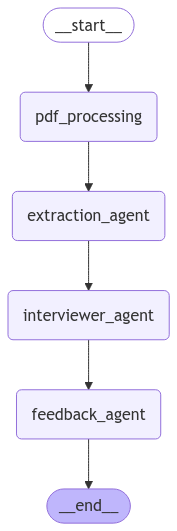

In [ ]:
from IPython.display import Image , display

display(Image(app.get_graph().draw_mermaid_png()))